In [1]:
#https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab
#Upload dataset from dropbox
!wget https://www.dropbox.com/s/p22xyqztwr41xpn/cell_images.zip?dl=0

--2019-05-05 22:59:51--  https://www.dropbox.com/s/p22xyqztwr41xpn/cell_images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/p22xyqztwr41xpn/cell_images.zip [following]
--2019-05-05 22:59:51--  https://www.dropbox.com/s/raw/p22xyqztwr41xpn/cell_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc475bfdb91006fdfb616c0f9c9e.dl.dropboxusercontent.com/cd/0/inline/AgU3ixIhPj4Bn2tnPAe4Ybd5z2TTMfs7MyIFpueqUMLF-vx6W5ZVVaMDpPQb3HnGpvNLOxPb4Xo0p7QQA20Smd7mgXJNcjOjVrHK-8zi1YTtAw/file# [following]
--2019-05-05 22:59:51--  https://uc475bfdb91006fdfb616c0f9c9e.dl.dropboxusercontent.com/cd/0/inline/AgU3ixIhPj4Bn2tnPAe4Ybd5z2TTMfs7MyIFpueqUMLF-vx6W5ZVVaMDpPQb3HnGpvNLOxPb4Xo0p7QQA20Smd7mgXJNcjOjVrHK-8zi1YTtAw/file
Re

In [2]:
!unzip cell_images.zip?dl=0 

Archive:  cell_images.zip?dl=0
   creating: cell_images/
   creating: cell_images/Parasitized/
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_164.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_165.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_166.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_167.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_168.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_171.png  
 extracting: cell_images/Parasitized/C100P61ThinF_IMG_2

In [3]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import os 
print (os.listdir("cell_images"))

['Uninfected', 'Parasitized']


In [0]:
data_dir = 'cell_images'

In [0]:
# Define transforms for the training and validation sets
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

**Dataset**

In [6]:
# Split the dataset into train, validation and test
train_data = 0.8
valid_data = 0.1
test_data = 0.1

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

22046 2755 2757
Training 22046 0.7999854851585746
Validation 2755 0.09997097031714929
Test 2757 0.10004354452427608


In [0]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [0]:
# Define the dataloaders using the image datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)

**Building and Training Network**

In [9]:
# Specify model architecture
# Load the pretrained model from pytorch
model_transfer = models.densenet201(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
  model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:06<00:00, 13440445.49it/s]


In [0]:
# Print out the model structure
print(model_transfer)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
print(model_transfer.classifier.in_features)
print(model_transfer.classifier.out_features)

1920
1000


In [0]:
# Freeze training for all 'features' layers
for param in model_transfer.features.parameters():
  param.requires_grad=False

In [11]:
# Total image label
num_classes = 2

n_inputs = model_transfer.classifier.in_features

# Add last linear layer (n_inputs -> 2 classes)
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, num_classes)

model_transfer.classifier = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
  model_transfer = model_transfer.cuda()
  
# Check to see the last layer produces the expected number of outputs
print(model_transfer.classifier.out_features)

2


In [0]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01, momentum=0.9)

In [19]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
  '''returns trained model'''
  # Initialize tracker for minimum validation loss
  valid_loss_min = np.inf
  
  for epoch in range(1, n_epochs+1):
    # Initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Model training
    model.train()
    for batch_idx, (data,target) in enumerate(trainloader):
      # Move to GPU
      if use_cuda:
        data,target = data.cuda(), target.cuda()
      
      # Clear the gradient of all optimized variables
      optimizer.zero_grad()
      # Forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # Calculate the batch loss
      loss = criterion(output, target)
      # Backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # Perform a single optimization step (parameter update)
      optimizer.step()
      # Record the average training loss
      train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
    
    # Model validation
    model.eval()
    for batch_idx, (data,target) in enumerate(validloader):
      # Move to GPU
      if use_cuda:
        data, target = data.cuda(), target.cuda()
      # Update the average validation loss
      # Forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # Calculate the batch loss
      loss = criterion(output, target)
      # Update the average validation loss
      valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
      
    # print training/validation stats
    print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
        epoch,
        train_loss,
        valid_loss))
    
    # Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_transfer.pt')
      valid_loss_min = valid_loss
  
  # Return trained model
  return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.43621 	Validation Loss: 0.41707
Validation loss decreased (inf --> 0.41707). Saving model ...
Epoch: 2 	Training Loss: 0.43368 	Validation Loss: 0.31836
Validation loss decreased (0.41707 --> 0.31836). Saving model ...
Epoch: 3 	Training Loss: 0.40546 	Validation Loss: 0.25991
Validation loss decreased (0.31836 --> 0.25991). Saving model ...
Epoch: 4 	Training Loss: 0.41397 	Validation Loss: 0.14586
Validation loss decreased (0.25991 --> 0.14586). Saving model ...
Epoch: 5 	Training Loss: 0.41247 	Validation Loss: 0.19349
Epoch: 6 	Training Loss: 0.42387 	Validation Loss: 0.56486
Epoch: 7 	Training Loss: 0.39519 	Validation Loss: 0.04867
Validation loss decreased (0.14586 --> 0.04867). Saving model ...
Epoch: 8 	Training Loss: 0.40953 	Validation Loss: 0.35061
Epoch: 9 	Training Loss: 0.42700 	Validation Loss: 0.49562
Epoch: 10 	Training Loss: 0.38797 	Validation Loss: 0.17729
Epoch: 11 	Training Loss: 0.39331 	Validation Loss: 0.24281
Epoch: 12 	Training Los

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

**Testing the Model**

In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.041953


Test Accuracy: 98% (2727/2757)


In [0]:
def predict_malaria(img_path):
    # load the image and return the class name
    # Image pre-processing
    image_transform = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
    
    # Prepare image
    img = Image.open(img_path)
    img_tensor=image_transform(img).unsqueeze(0) 
        
    # If use gpu
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    # Turn on to evaluation mode
    model_transfer.eval()
    
    # Prediction
    output = model_transfer(img_tensor)
    pred = torch.argmax(output).item()

    # Turn off evaluation mode
    model_transfer.train()
        
    # Predict the class name
    category= class_name[pred]
    
    return category

Parasitized


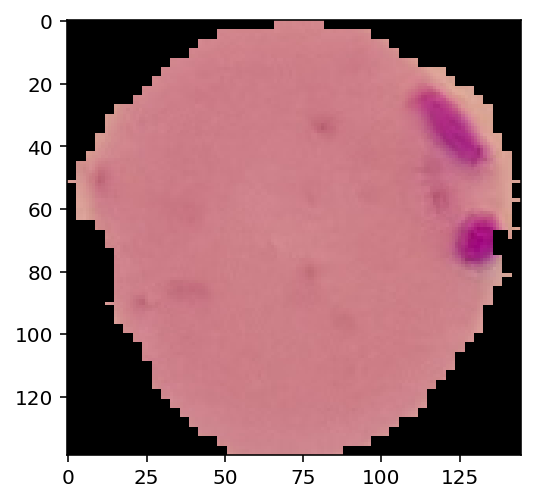

Parasitized


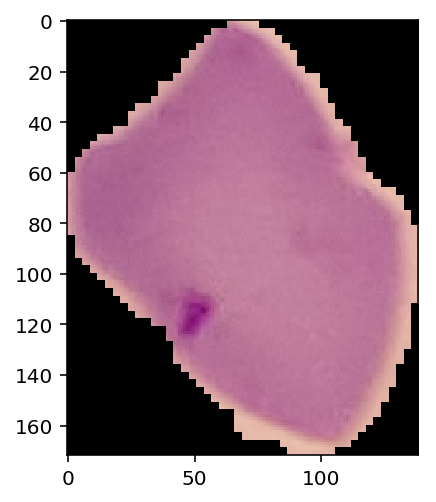

Parasitized


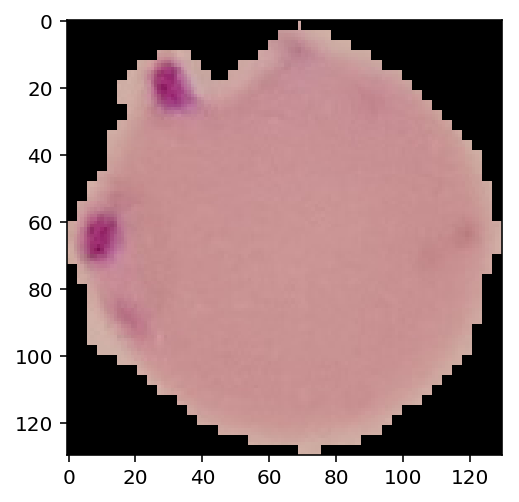

Parasitized


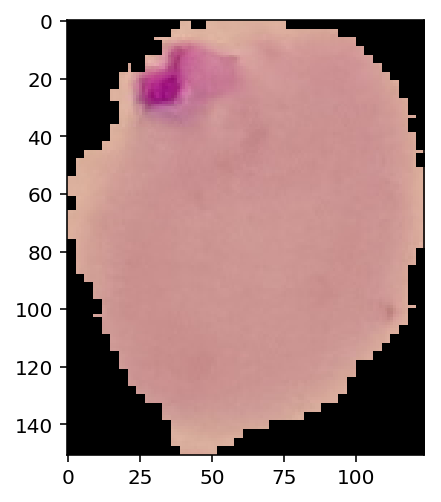

Parasitized


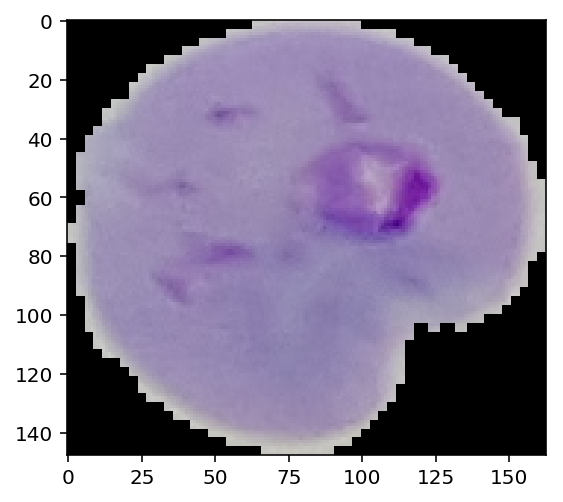

Uninfected


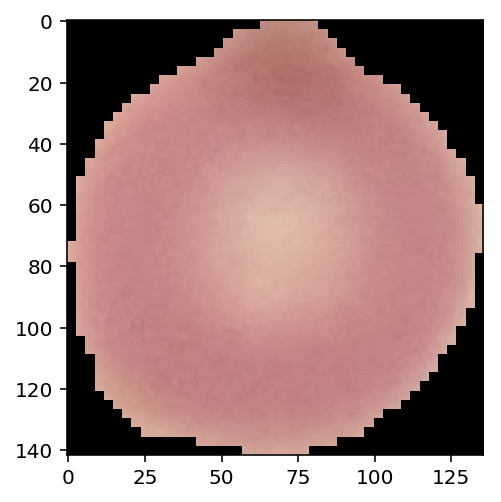

Uninfected


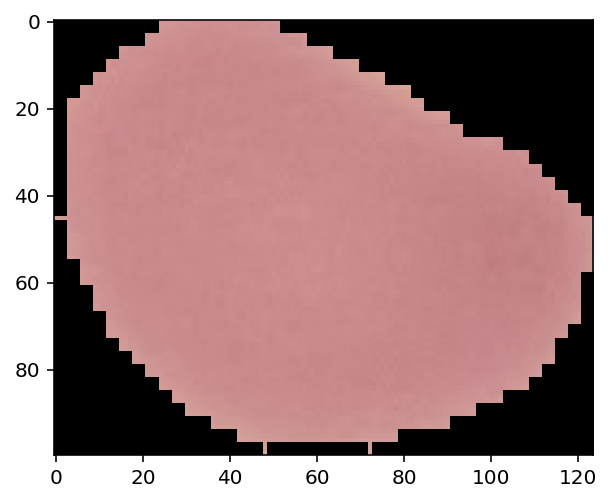

Uninfected


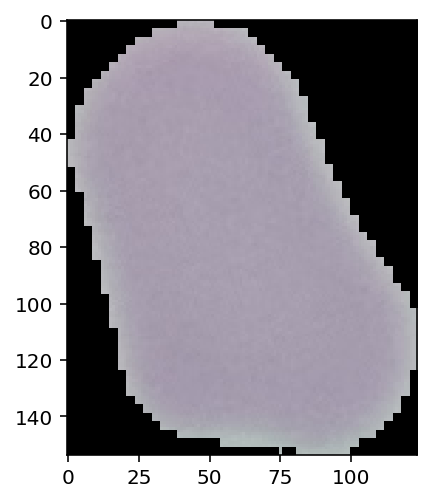

Uninfected


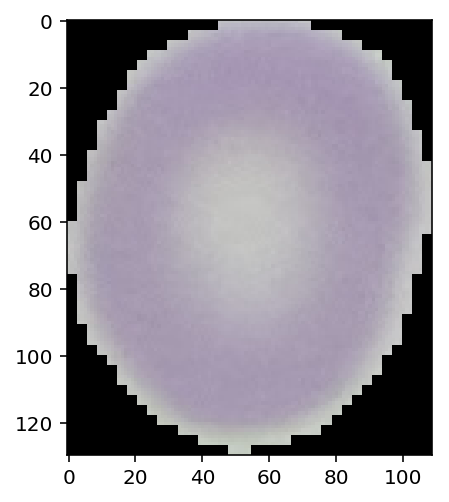

Uninfected


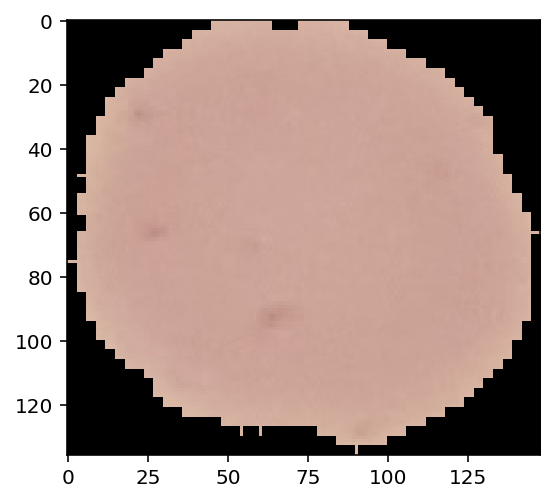

In [57]:
from glob import glob
from PIL import Image
from termcolor import colored

class_name =['Parasitized', 'Uninfected']
infected = np.array(glob("cell_images/Parasitized/*"))
not_infected = np.array(glob("cell_images/Uninfected/*"))

for i in range(5):
  img_path = infected[i]
  img = Image.open(img_path)
  if predict_malaria(img_path) == 'Parasitized':
    print(colored('Parasitized', 'blue'))
  else:
    print(colored('Uninfected', 'red'))
  plt.imshow(img)
  plt.show()
  
for i in range(5):
  img_path = not_infected[i]
  img = Image.open(img_path)
  if predict_malaria(img_path) == 'Uninfected':
    print(colored('Uninfected', 'red'))
  else:
    print(colored('Parasitized', 'blue'))
  plt.imshow(img)
  plt.show()